# Develop `velocity_section_and_surface` Figure Module

Development of functions for `nowcast.figures.research.velocity_section_and_surface` web site figure module.

This is an example of developing the functions for a web site figure module in a notebook.
It follows the function organization patterns described in
[Creating a Figure Module](https://salishsea-nowcast.readthedocs.io/en/latest/figures/create_fig_module.html) docs.

Notebooks like this should be developed in a
[Nowcast Figures Development Environment](https://salishsea-nowcast.readthedocs.io/en/latest/figures/fig_dev_env.html)
so that all of the necessary dependency packages are installed.
The development has to be done on a workstation that has the Salish Sea Nowcast system `/results/` parition mounted.

If you choose to develop your figure in a notebook,
the next step is to create a module like
`nowcast.figures.research.tracer_thalweg_and_surface`
and a notebook like
[TestTracerThalwegAndSurfaceModule](https://nbviewer.jupyter.org/urls/bitbucket.org/salishsea/salishseanowcast/raw/tip/notebooks/figures/research/TestTracerThalwegAndSurface.ipynb)
that tests it in the nowcast system context.

In [1]:
import datetime
import os
from types import SimpleNamespace

import cmocean
import matplotlib.pyplot as plt
from matplotlib import gridspec
import netCDF4 as nc
import numpy as np
import scipy.io as sio

import salishsea_tools
from salishsea_tools import visualisations as vis
from salishsea_tools import tidetools, viz_tools

import nowcast
import nowcast.figures.website_theme

/home/yingkai/anaconda/envs/nowcast-fig-dev/lib/python3.6/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
%matplotlib inline

We know for sure that we need to develop:

* a `_prep_plot_data()` function
* a `_prep_fig_axes()` function
* a `make_figure()` function that the `make_plots` worker will call

Since the figure will have 2 axes
(a vertical thalweg slice, and a horizontal surface slice)
we also know that we need to develop 2 axes plotting functions:

* `_plot_tracer_thalweg()`
* `_plot_tracer_surface()`

## `_prep_plot_data()` Function

In [3]:
def _prep_plot_data(U_var, V_var, mesh_mask, hr=0, lims=(0, 350, 0, 450)):
    sj, ej = 200, 770
    si, ei = 20, 370
    
    U_hr = U_var[hr]
    V_hr = V_var[hr]
    U_masked = np.ma.masked_where(
        mesh_mask["umask"][0, ...] == 0, U_hr)
    V_masked = np.ma.masked_where(
        mesh_mask["vmask"][0, ...] == 0, V_hr)
    U_surface = U_masked[0, sj:ej, si:ei]
    V_surface = V_masked[0, sj:ej, si:ei]
    
    # Add unstagger code here
        
    return SimpleNamespace(
        U_var=U_var,
        V_var=V_var,
        U_hr=U_hr,
        V_hr=V_hr,
        U_surface=U_surface,
        V_surface=V_surface,
        surface_j_limits=(sj, ej),
        surface_i_limits=(si, ei),
        depth_limits=lims[:2],
        length_limits=lims[2:],
        depth = mesh_mask["gdept_1d"][0, ...],
    )

In [4]:
bathy = nc.Dataset('/results/nowcast-sys/NEMO-forcing/grid/bathy_downonegrid2.nc')

mesh_mask = nc.Dataset('/results/nowcast-sys/NEMO-forcing/grid/mesh_mask_downbyone2.nc')

U = nc.Dataset('/results/SalishSea/nowcast-green/25apr17/SalishSea_1h_20170425_20170425_grid_U.nc')

V = nc.Dataset('/results/SalishSea/nowcast-green/25apr17/SalishSea_1h_20170425_20170425_grid_V.nc')

U_var = U.variables['vozocrtx']

V_var = V.variables['vomecrty']

Confirm that `_prep_plot_data()` is doing what we want.
Lots of tests are possible,
but we'll just confirm that the shapes of the data arrays to be plotted
are what we expect.

In [5]:
plot_data = _prep_plot_data(U_var, V_var, mesh_mask)

print(plot_data.U_hr.shape)
print(plot_data.U_surface.shape)
print(np.arange(*plot_data.surface_i_limits, dtype=int).shape)

(40, 898, 398)
(570, 350)
(350,)


## `_prep_fig_axes() Function`

In [6]:
def _prep_fig_axes(figsize, theme):
    fig = plt.figure(
        figsize=figsize, facecolor=theme.COLOURS['figure']['facecolor'])

    gs = gridspec.GridSpec(2, 2, width_ratios=[1.3, 1])
    
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax_section = [ax1, ax2]
    for ax in ax_section:
        ax.set_axis_bgcolor(theme.COLOURS['axes']['background'])
        ax.invert_yaxis()
        ax.xaxis.tick_top()

    ax_surface = fig.add_subplot(gs[:, 1])
    ax_surface.set_axis_bgcolor(theme.COLOURS['axes']['background'])

    return fig, (ax_section, ax_surface)

## `_plot_tracer_thalweg()` Function

Because our figure is going to show 2 views of the tracer
(a vertical slice along the thalweg,
and a horizontal slice on the ocean surface)
it would be nice to use the same contour colour levels if appropriate.
But it won't be appropriate if the values contoured on the surface are
depth averaged.
It's also possible that the tracer concentration ranges will be different
enough in the 2 slices that common contour levels don't make sense.

So,
we come up with a function that calculates contour levels for the two axes
and decides whether whether the levels are similar enough that one colour bar
is sufficient for the figure, or if each axes requires one.

In [35]:
def _plot_vel_section(fig, AX, v_hr, deptht, bathy, sj=425, si=200, ei=325):
    """FOR KYLE
    """
    idz = 25 # where to break the y-axis
    # variables
    bathy = bathy[sj, si:ei]
    v_up = v_hr[:idz+1, sj, si:ei]
    v_dw = v_hr[idz-1:, sj, si:ei]
    gridx_1d = np.arange(si, ei)
    gridx_up, gridz_up = np.meshgrid(gridx_1d, deptht[:idz+1])
    gridx_dw, gridz_dw = np.meshgrid(gridx_1d, deptht[idz-1:])
    # v-velocity contour levels
    lev = np.array([-0.55, -0.45, -0.35, -0.25, -0.15, -0.05, 0.05, 0.15, 0.25, 0.35, 0.45, 0.55])
    # fig
    ax1 = AX[0]; ax2 = AX[1]
    ax1.set_ylim([deptht[idz], deptht[0]])
    ax2.set_ylim([deptht[-1], deptht[idz]])
    [i.set_linewidth(2.5) for i in ax1.spines.values()]
    [i.set_linewidth(2.5) for i in ax2.spines.values()]
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off',   
                    labeltop='on', labelbottom='off', labelleft='on', labelright='off')
    ax2.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off',   
                    labeltop='off', labelbottom='on', labelleft='on', labelright='off')
    # plot "/" as diag.
    d = 0.01
    kwargs = dict(transform=ax1.transAxes, color='w', linewidth=1.5, zorder=4, clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)
    ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
    ax2.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
    # contours on the upper side
    CS = ax1.contourf(gridx_up, gridz_up, v_up, lev, cmap=plt.cm.RdBu_r, extend='both', zorder=1)
    ax1.contour( gridx_up, gridz_up, v_up, lev, colors=('gray',), linewidths=(1.0,), zorder=2)
    ax1.fill_between(gridx_1d, bathy, deptht[idz], facecolor='burlywood', linewidth=0, zorder=3)
    # contours on the lower side
    ax2.contourf(gridx_dw, gridz_dw, v_dw, lev, cmap=plt.cm.RdBu_r, extend='both', zorder=1)
    ax2.contour( gridx_dw, gridz_dw, v_dw, lev, colors=('gray',), linewidths=(1.0,), zorder=2)
    ax2.fill_between(gridx_1d, bathy, deptht[-1], facecolor='burlywood', linewidth=0, zorder=3)
    # colorbar
    cax = fig.add_axes([0.45, 0.075, 0.02, 0.375])
    CBar = fig.colorbar(CS, cax=cax, orientation='vertical')
    CBar.ax.tick_params(axis='y', length=25, direction='in', labelsize=14)
    CBar.ax.xaxis.set_label_position('top')
    CBar.set_ticks(lev)
    CBar.ax.set_xticklabels(lev, rotation=45)
    CBar.set_label('[m/s]', y=1.065, labelpad=-55, fontsize=16, rotation=360)
    # tight layout
    plt.tight_layout(h_pad=1)
    return AX

## `_thalweg_axes_labels()` Function

We also put the code for labeling and prettifying the axes in a separate function.
Along the way,
we pull the code that we use to label either colour bar out into a separate function
that both `_thalweg_axes_labels()` and `_surface_axes_labels()` can make use of.

In [8]:
def _cbar_labels(cbar, contour_intervals, theme, label):
    cbar.set_ticks(contour_intervals)
    cbar.ax.axes.tick_params(labelcolor=theme.COLOURS['cbar']['tick labels'])
    cbar.set_label(
        label,
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis'])

In [9]:
def _section_axes_labels(ax, plot_data, theme):
    ax.set_xlim(plot_data.length_limits)
    ax.set_ylim(
        plot_data.depth_limits[1], plot_data.depth_limits[0])
    ax.set_xlabel(
        'Distance [km]', color=theme.COLOURS['text']['axis'],
        fontproperties=theme.FONTS['axis'])
    ax.set_ylabel(
        'Depth [m]', color=theme.COLOURS['text']['axis'],
        fontproperties=theme.FONTS['axis'])
    theme.set_axis_colors(ax)

## `_plot_tracer_surface()` Function

In [10]:
def _plot_vel_surface(ax, plot_data):
    x, y = np.meshgrid(
        np.arange(*plot_data.surface_i_limits, dtype=int),
        np.arange(*plot_data.surface_j_limits, dtype=int))
    Q = ax.quiver(
        x, y, plot_data.U_surface, plot_data.V_surface)
    return Q

## `_surface_axes_labels()` Function

In [11]:
def _surface_axes_labels(ax, theme):
    ax.set_xlabel(
        'Grid x', color=theme.COLOURS['text']['axis'],
        fontproperties=theme.FONTS['axis'])
    ax.set_ylabel(
        'Grid y', color=theme.COLOURS['text']['axis'],
        fontproperties=theme.FONTS['axis'])
    ax.set_axis_bgcolor('burlywood')
    viz_tools.set_aspect(ax)
    theme.set_axis_colors(ax)

## `make_figure()` Function

This is is the function that will be called by the `nowcast.workers.make_plots` worker to return a `matplotlib.figure.Figure` object.

In [24]:
def make_figure(
    U_var, V_var, bathy, mesh_mask, cmap,  depth_integrated,
    figsize=(20, 12), theme=nowcast.figures.website_theme
):
    plot_data = _prep_plot_data(U_var, V_var, mesh_mask)
    fig, (ax_section, ax_surface) = _prep_fig_axes(figsize, theme)
    
#     for ax in ax_section:
#         cbar_section = _plot_vel_section(
#             ax, plot_data, bathy, mesh_mask, cmap)
#         _section_axes_labels(
#             ax, theme)
    _plot_vel_section(fig, ax_section, plot_data.V_hr, plot_data.depth, bathy, sj=425, si=200, ei=325)

    Q = _plot_vel_surface(ax_surface, plot_data)
    _surface_axes_labels(ax_surface, theme)
    return fig

## Render the Figure

The `%%timeit` cell magic lets us keep an eye on how log the figure takes to process.
Setting `-n1 -r1` prevents it from processing the figure more than once
as it might try to do to generate better statistics.

/home/yingkai/anaconda/envs/nowcast-fig-dev/lib/python3.6/site-packages/ipykernel_launcher.py:2: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  
/home/yingkai/anaconda/envs/nowcast-fig-dev/lib/python3.6/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


747 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


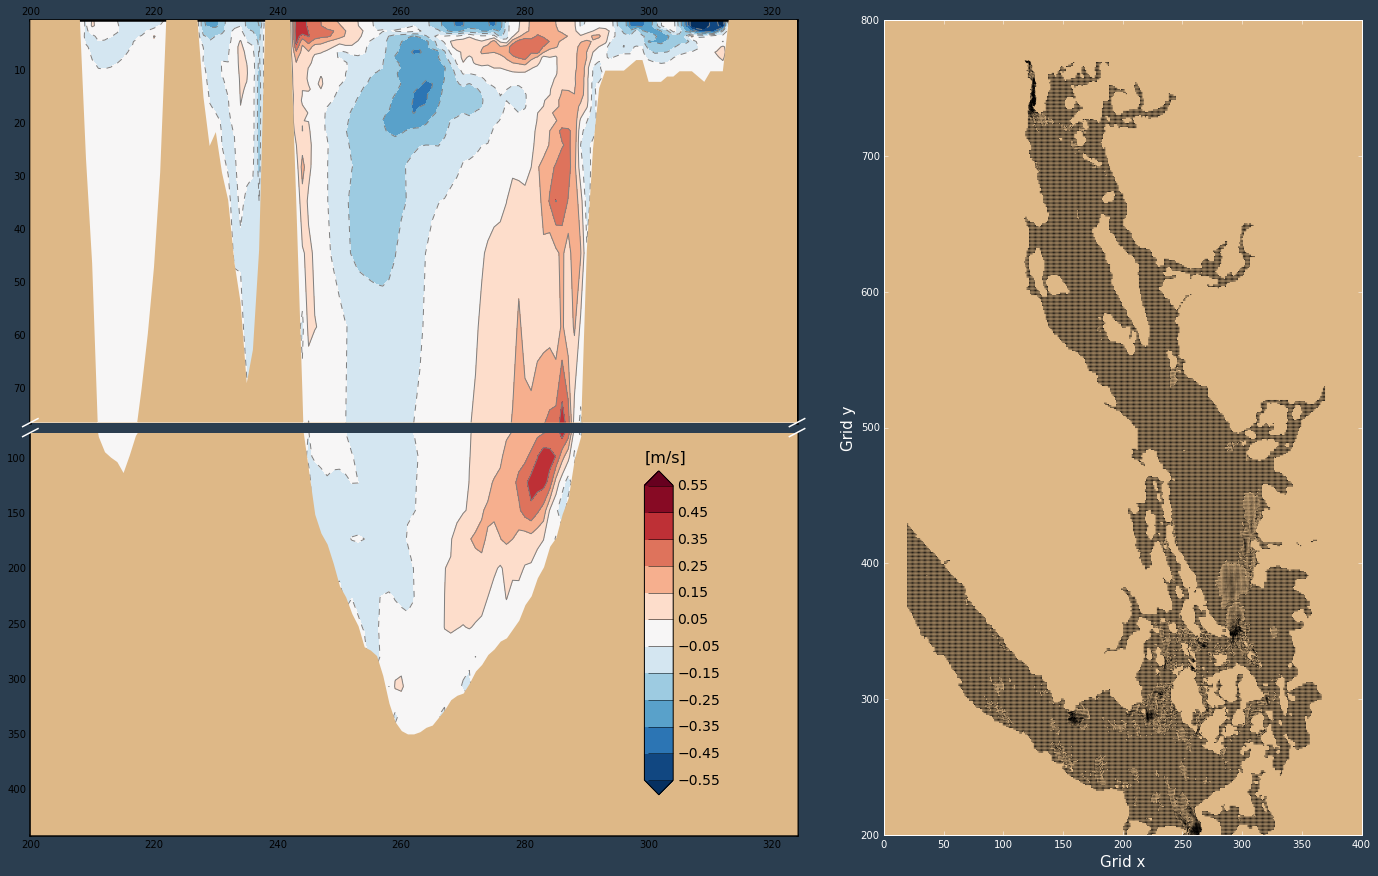

In [36]:
%%timeit -n1 -r1
bathy_array = bathy.variables['Bathymetry'][...]
bathy_array[bathy_array.mask] = 0
fig = make_figure(
    U_var, V_var, bathy_array, mesh_mask, cmap=cmocean.cm.algae, depth_integrated=True)

In [16]:
bathy.variable['Bathymetry'][...],

AttributeError: NetCDF: Attribute not found

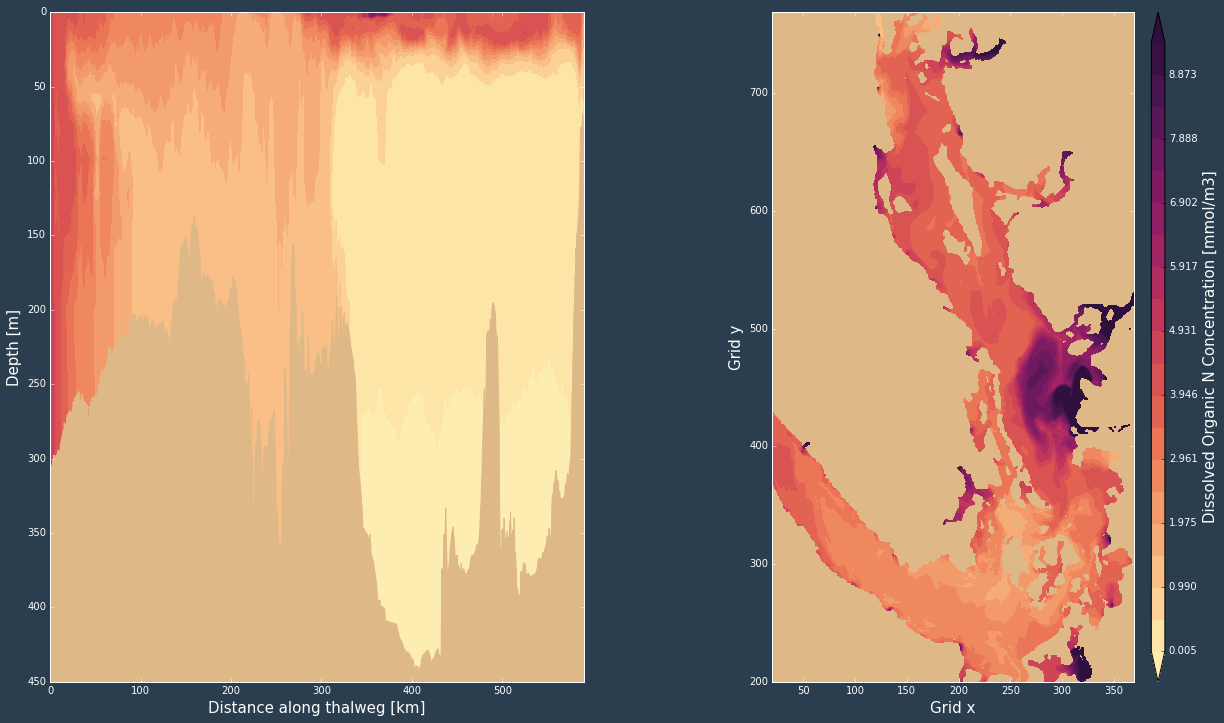

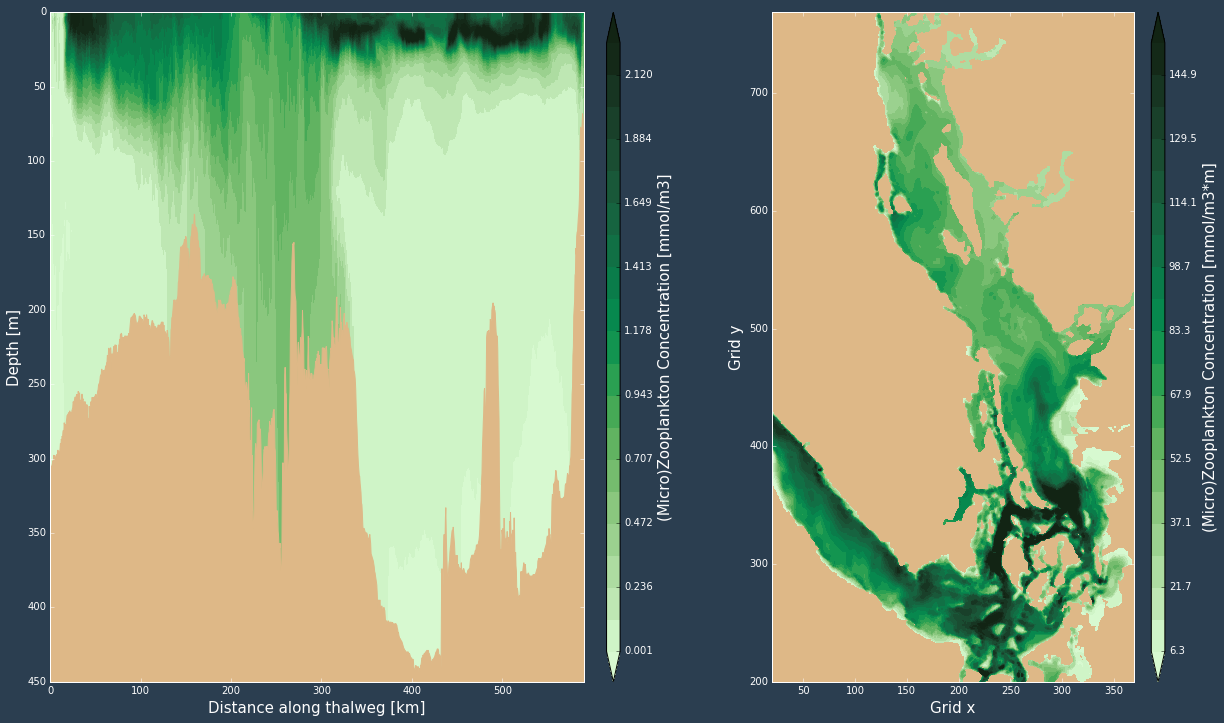

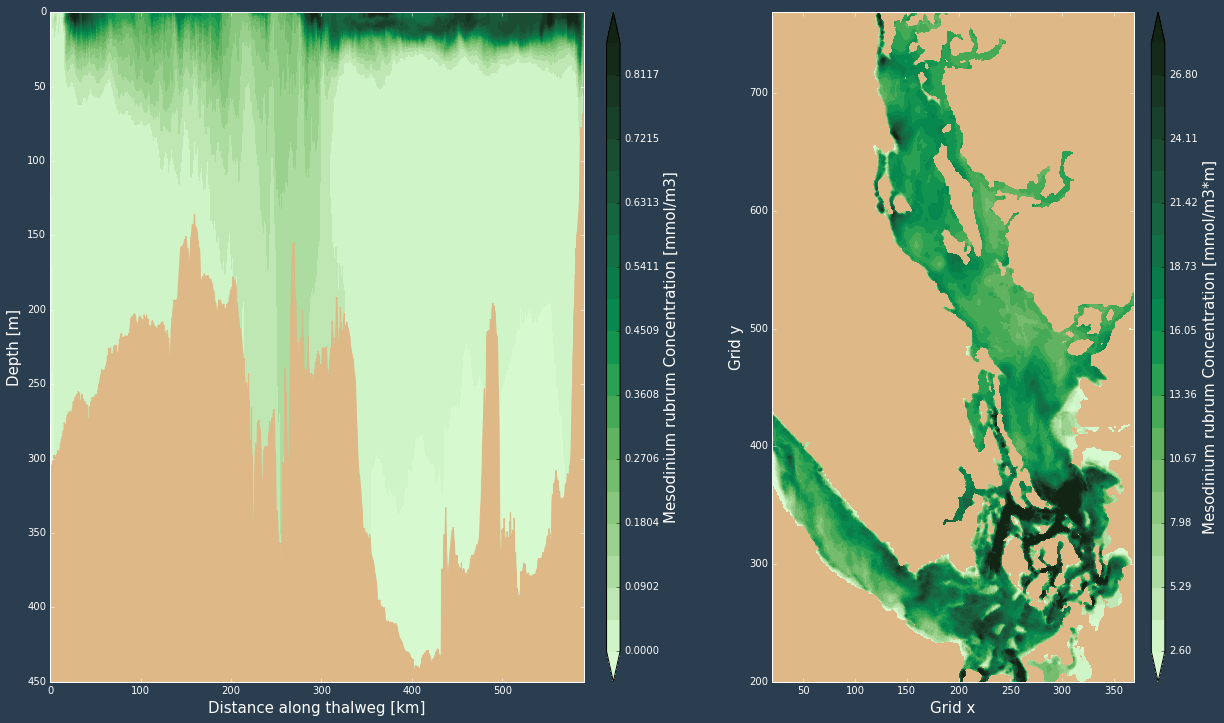

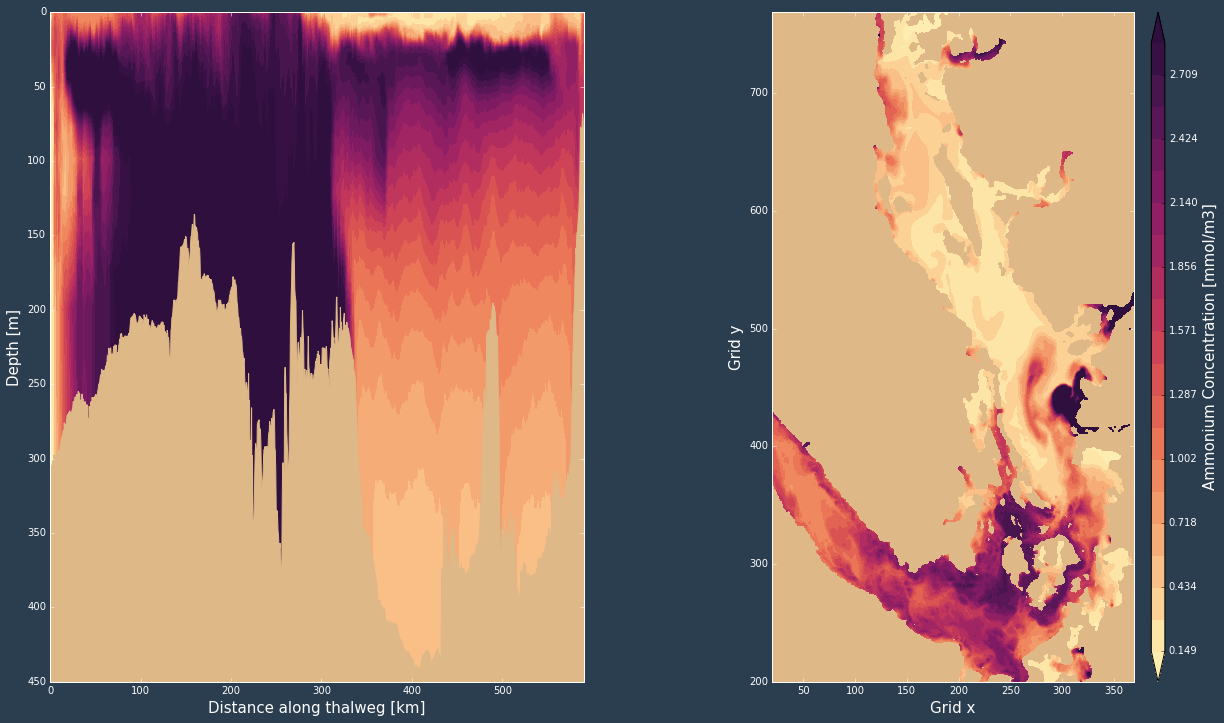

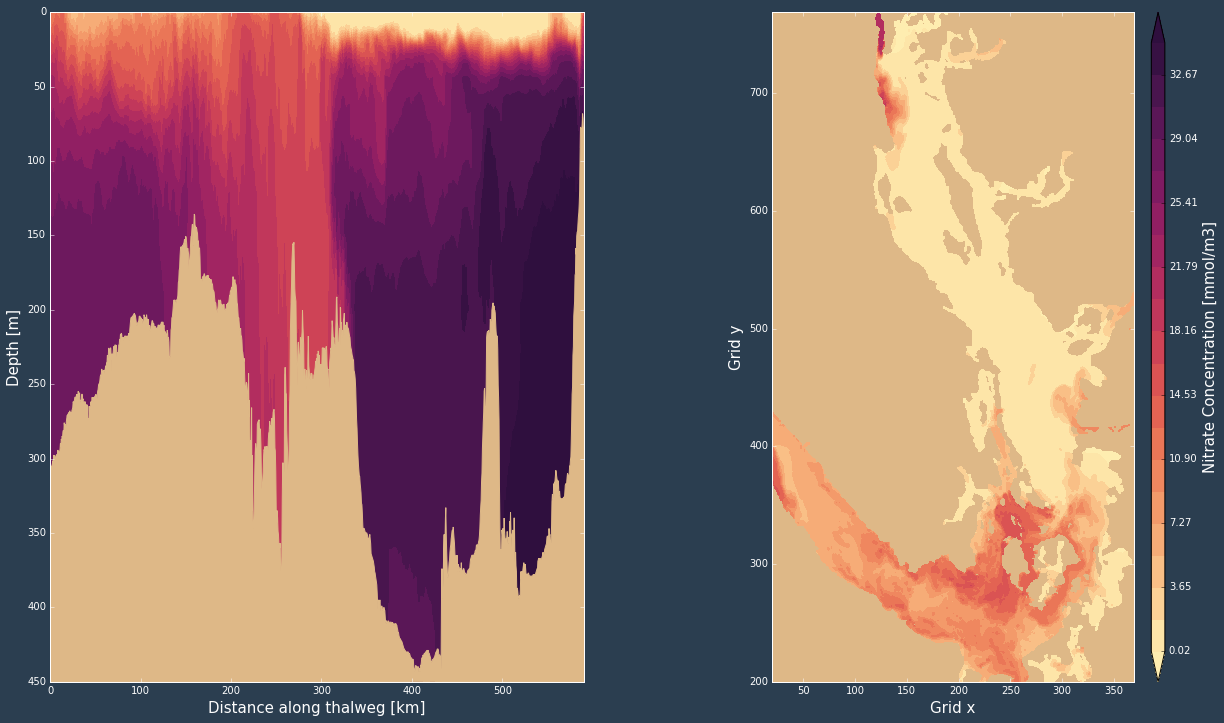

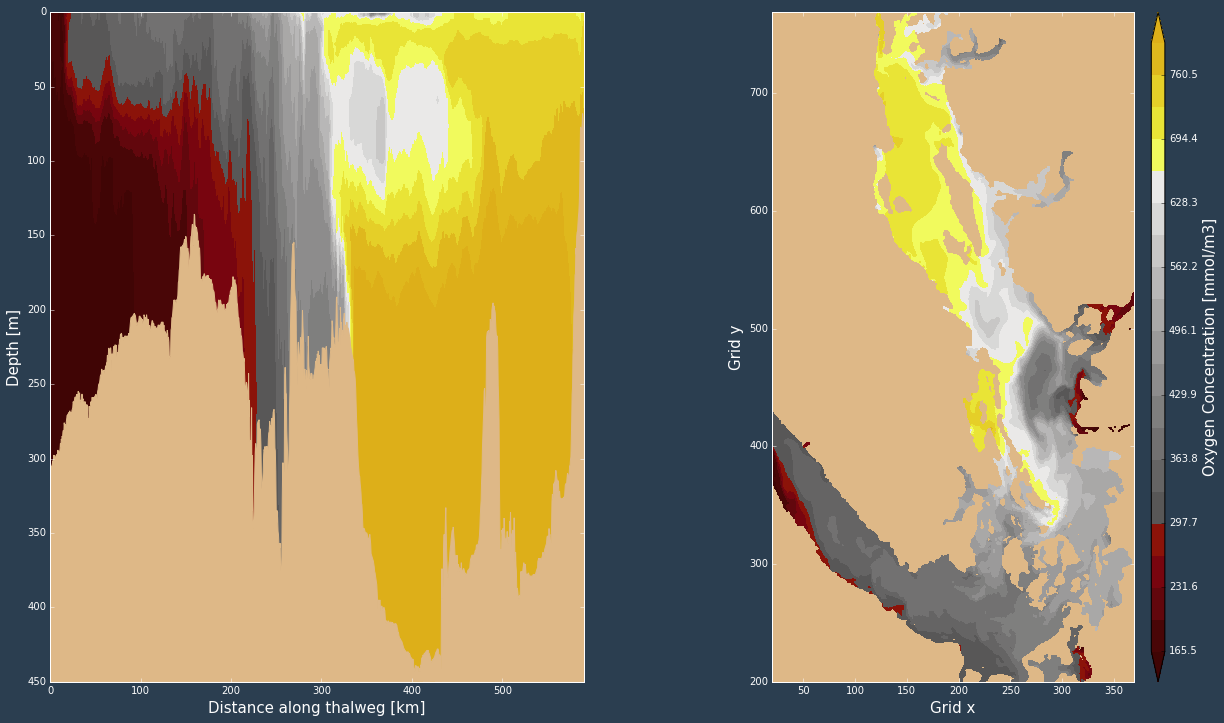

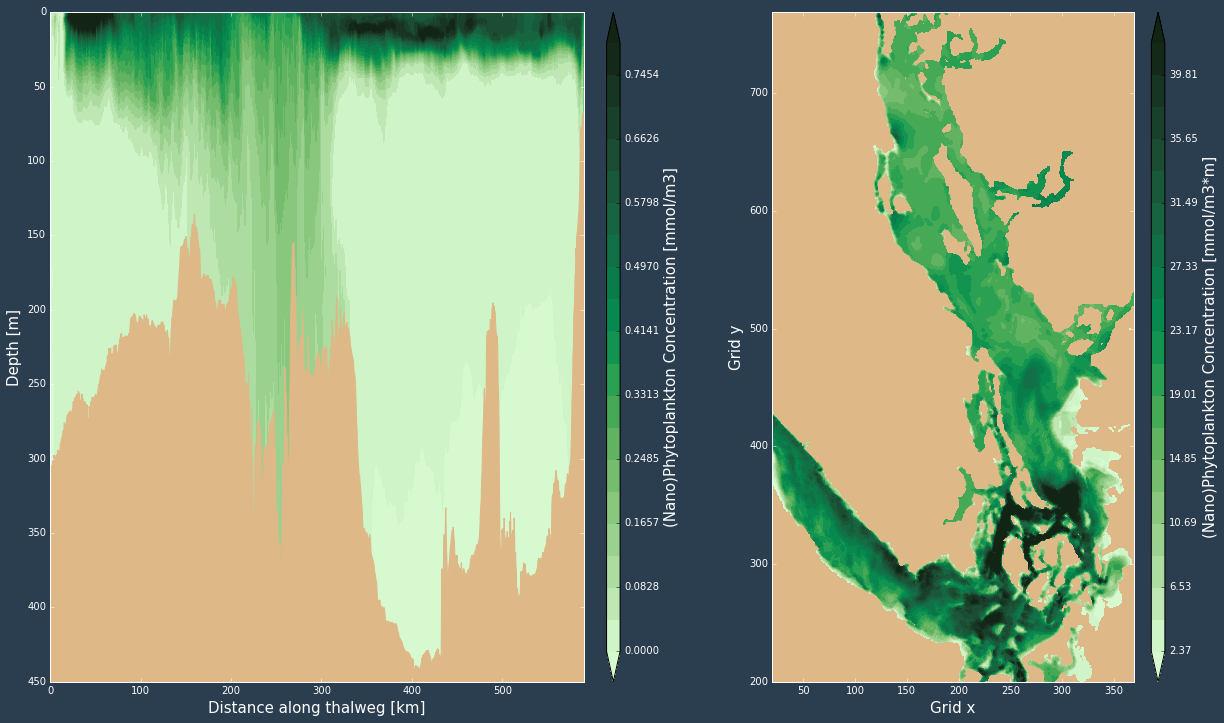

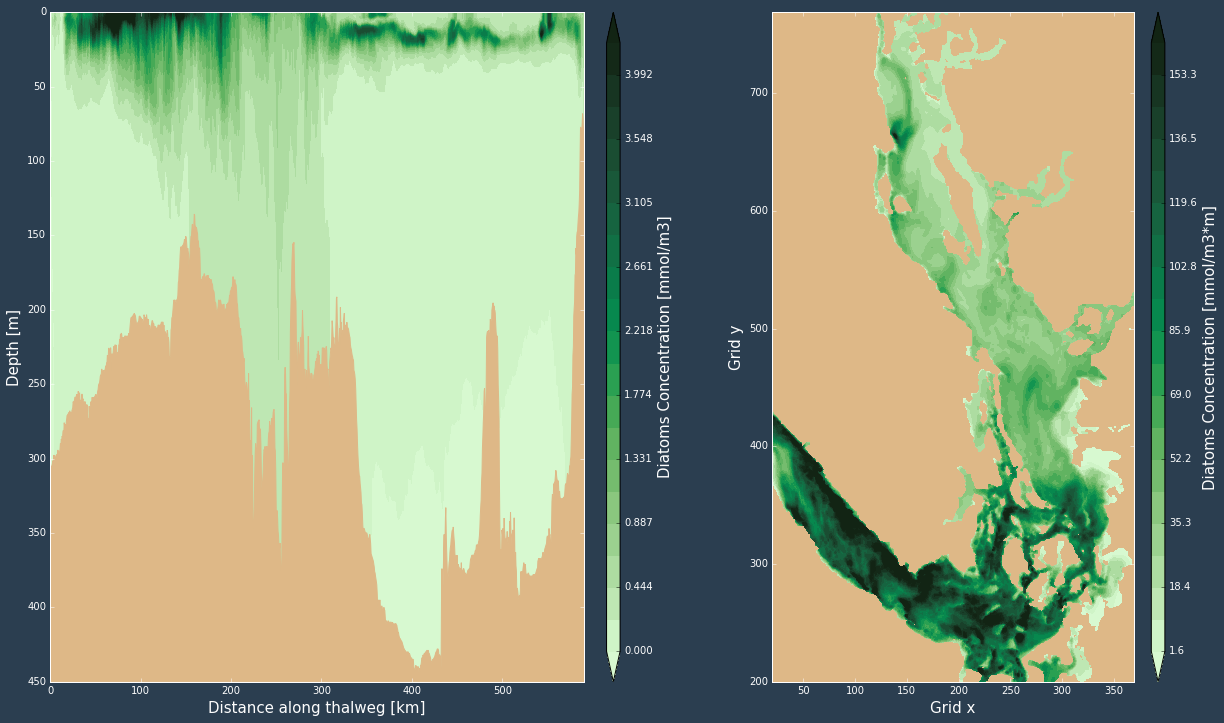

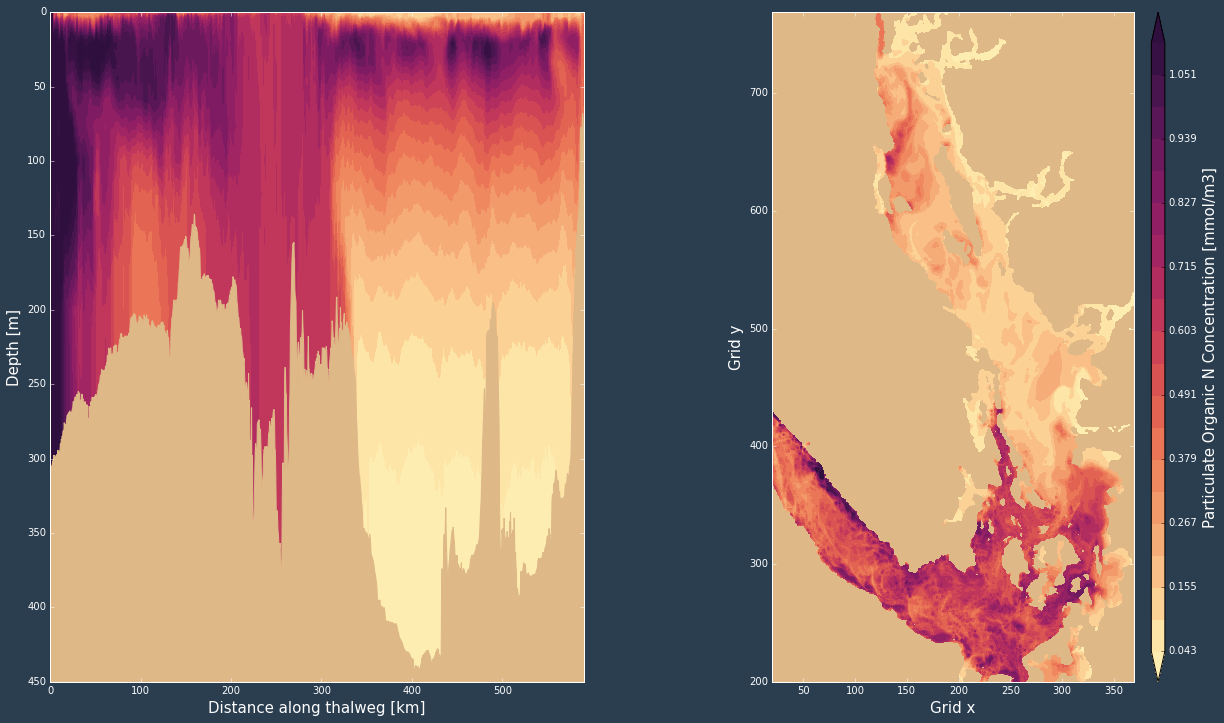

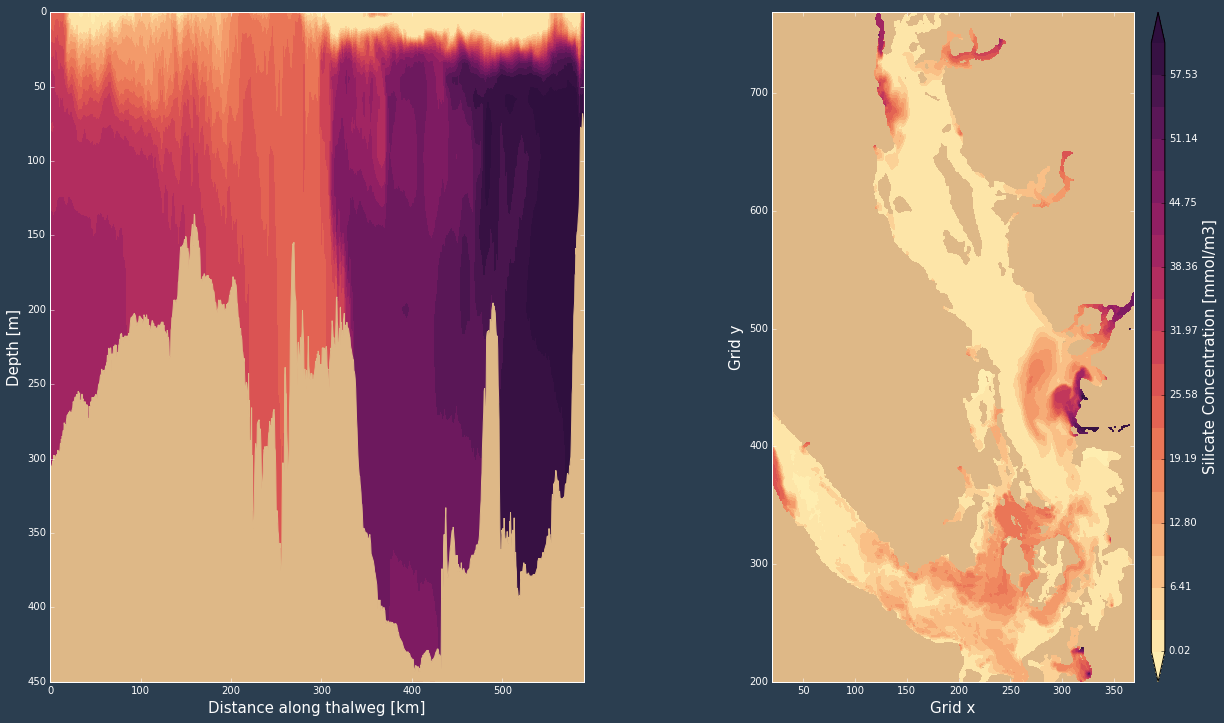

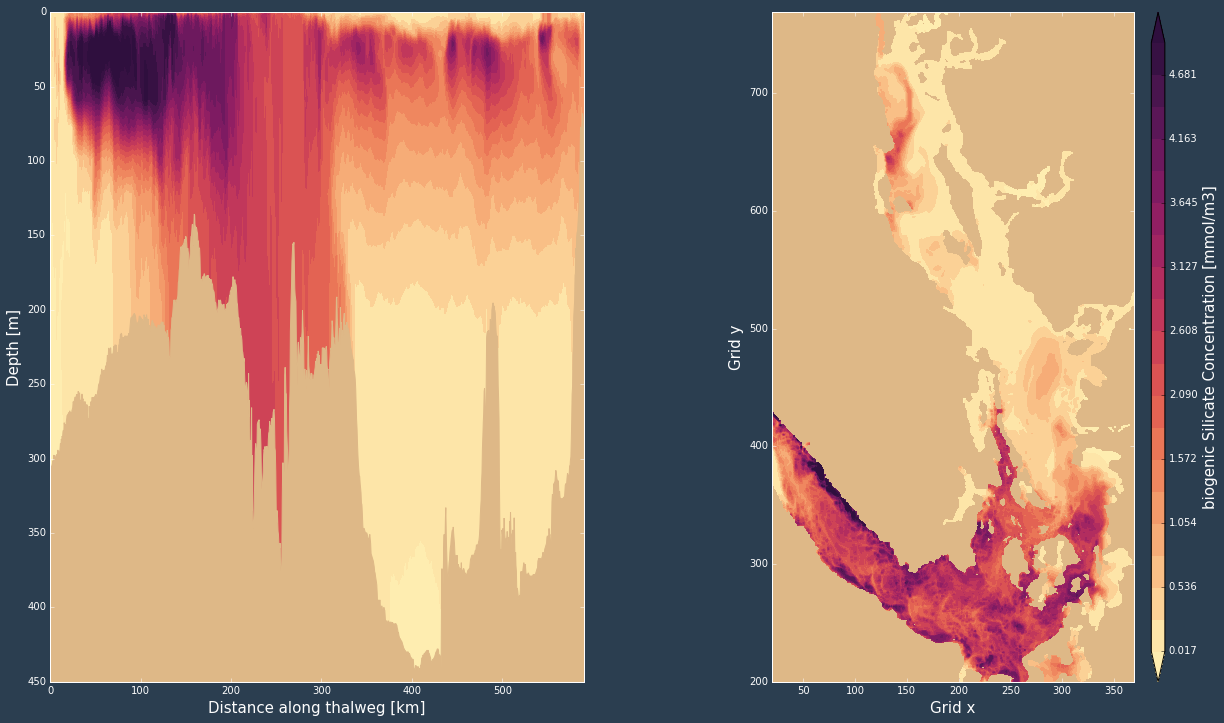

In [15]:
tracers = {
    'DOC': {'cmap': cmocean.cm.matter, 'depth_integrated': False},
    'MICZ': {'cmap': cmocean.cm.algae, 'depth_integrated': True},
    'MYRI': {'cmap': cmocean.cm.algae, 'depth_integrated': True},
    'NH4': {'cmap': cmocean.cm.matter, 'depth_integrated': False},
    'NO3': {'cmap': cmocean.cm.matter, 'depth_integrated': False},
    'O2': {'cmap': cmocean.cm.oxy, 'depth_integrated': False},
    'PHY': {'cmap': cmocean.cm.algae, 'depth_integrated': True},
    'PHY2': {'cmap': cmocean.cm.algae, 'depth_integrated': True},
    'POC': {'cmap': cmocean.cm.matter, 'depth_integrated': False},
    'Si': {'cmap': cmocean.cm.matter, 'depth_integrated': False},
    'bSi': {'cmap': cmocean.cm.matter, 'depth_integrated': False},
}
for tracer in tracers:
    tracer_var = ptrc_T.variables[tracer]
    fig = make_figure(
        tracer_var, bathy, mesh_mask, 
        cmap=tracers[tracer]['cmap'], 
        depth_integrated=tracers[tracer]['depth_integrated']
    )